<a href="https://colab.research.google.com/github/larasauser/master/blob/main/Whitt_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio tqdm scikit-image scikit-learn --quiet

import os
from glob import glob
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.linalg import lstsq
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# --- Dossiers ---
DRIVE_CLEAR_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_herens_Landsat8'
DRIVE_MASKED_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_herens_Landsat8_holes'
DRIVE_MODIS_FOLDER = '/content/drive/MyDrive/Whitt/NDVI_herens_MODIS'
OUTPUT_FOLDER = '/content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# --- Paramètres ---
WINDOW_METERS = 200.0      # Taille de la fenêtre pour voisins MODIS
KAPPA = 5.0                # Whittaker smoothing
MIN_OVERLAP = 3            # Min nb de points pour calcul linéaire
MODIS_WINDOW_DAYS = 16     # Nombre de jours autour de la date Landsat pour sélectionner MODIS


In [ ]:
def parse_date_from_filename(fn):
    import re
    m = re.search(r'(\d{4})-(\d{2})-(\d{2})', os.path.basename(fn))
    if m:
        return datetime.strptime(''.join(m.groups()), '%Y%m%d').date()
    return datetime.fromtimestamp(os.path.getmtime(fn)).date()

def read_singleband_tif(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    nd = meta.get('nodata', None)
    if nd is not None:
        arr[arr==nd] = np.nan
    return arr, meta

def resample_to_target(src_arr, src_meta, target_meta):
    dst_arr = np.full((target_meta['height'], target_meta['width']), np.nan, dtype=np.float32)
    reproject(
        source=src_arr,
        destination=dst_arr,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

In [ ]:
# --- Charger images Landsat ---
clear_files = sorted(glob(os.path.join(DRIVE_CLEAR_FOLDER, '*.tif')))
masked_files = sorted(glob(os.path.join(DRIVE_MASKED_FOLDER, '*.tif')))

# --- Trouver la référence (plus petite image) ---
sizes = []
for f in clear_files:
    arr, meta = read_singleband_tif(f)
    sizes.append((arr.shape[0]*arr.shape[1], f, arr.shape, meta))
sizes.sort()
_, ref_file, ref_shape, ref_meta = sizes[0]
H_ref, W_ref = ref_shape
PIXEL_SIZE_M = abs(ref_meta['transform'][0])
print("Reference Landsat:", os.path.basename(ref_file), "shape:", ref_shape)

# --- Stacker les images ---
landsat_clear_stack, landsat_masked_stack = [], []
clear_dates, masked_dates = [], []

for f in clear_files:
    arr, meta = read_singleband_tif(f)
    if arr.shape != ref_shape:
        arr = resample_to_target(arr, meta, ref_meta)
    landsat_clear_stack.append(arr)
    clear_dates.append(parse_date_from_filename(f))

for f in masked_files:
    arr, meta = read_singleband_tif(f)
    if arr.shape != ref_shape:
        arr = resample_to_target(arr, meta, ref_meta)
    landsat_masked_stack.append(arr)
    masked_dates.append(parse_date_from_filename(f))

landsat_clear_stack = np.stack(landsat_clear_stack, axis=0)
landsat_masked_stack = np.stack(landsat_masked_stack, axis=0)
T, H, W = landsat_clear_stack.shape
print("Stacks shapes (clear/masked):", landsat_clear_stack.shape, landsat_masked_stack.shape)

Reference Landsat: NDVI_2013-11-12.tif shape: (757, 788)
Stacks shapes (clear/masked): (66, 757, 788) (6, 757, 788)


In [ ]:
modis_files = sorted(glob(os.path.join(DRIVE_MODIS_FOLDER, '*.tif')))
modis_map = {parse_date_from_filename(f): f for f in modis_files}
modis_dates_list = sorted(modis_map.keys())

# --- Créer un stack MODIS multiple par date Landsat ---
modis_stack = np.full((T, H, W), np.nan, dtype=np.float32)

for ti, d in enumerate(clear_dates):
    # --- Sélectionner toutes les MODIS dans +/- MODIS_WINDOW_DAYS ---
    selected_modis = [md for md in modis_dates_list if abs((md - d).days) <= MODIS_WINDOW_DAYS]
    if len(selected_modis) == 0:
        continue
    mod_arrs = []
    for md in selected_modis:
        arr, meta = read_singleband_tif(modis_map[md])
        arr_resampled = resample_to_target(arr, meta, ref_meta)
        mod_arrs.append(arr_resampled)
    # Moyenne de toutes les MODIS sélectionnées pour cette date Landsat
    modis_stack[ti] = np.nanmean(np.stack(mod_arrs, axis=0), axis=0)

print("MODIS stack aligned (multi-image):", modis_stack.shape)


MODIS stack aligned (multi-image): (66, 757, 788)


In [ ]:
# === 5.1 Fonctions helpers EGF ===
def pearson_r(a, b):
    valid = ~np.isnan(a) & ~np.isnan(b)
    if valid.sum() < 2:
        return np.nan
    x, y = a[valid], b[valid]
    xm, ym = x.mean(), y.mean()
    num = np.sum((x - xm) * (y - ym))
    den = np.sqrt(np.sum((x - xm)**2) * np.sum((y - ym)**2))
    if den == 0:
        return np.nan
    return num / den

def compute_M_reference_pixel(i, j, modis_stack, sl_target_ts, radius_pix, corr_threshold=0.3):
    T, H, W = modis_stack.shape
    i0, i1 = max(0, i - radius_pix), min(H, i + radius_pix + 1)
    j0, j1 = max(0, j - radius_pix), min(W, j + radius_pix + 1)
    coords = [(ii, jj) for ii in range(i0, i1) for jj in range(j0, j1)]

    corrs, mseries = [], []
    for ii, jj in coords:
        ms = modis_stack[:, ii, jj]
        r = pearson_r(ms, sl_target_ts)
        if np.isnan(r) or r < corr_threshold:
            continue
        corrs.append(r)
        mseries.append(ms)

    if len(corrs) == 0:
        return None

    R = np.array(corrs)
    ms_valid = np.array(mseries)

    # Normalisation des corrélations pour pondération
    R = (R - R.min()) / (R.max() - R.min()) if R.max() != R.min() else np.ones_like(R)
    weights = R / R.sum()

    # Calcul de Mref pondéré
    Mref = np.zeros(T, dtype=float)
    support = np.zeros(T, dtype=float)
    for w, ms in zip(weights, ms_valid):
        valid_t = ~np.isnan(ms)
        Mref[valid_t] += w * ms[valid_t]
        support[valid_t] += w
    Mref[support == 0] = np.nan
    return Mref

def estimate_linear_transfer(M_ref, SL_ts):
    valid = ~np.isnan(M_ref) & ~np.isnan(SL_ts)
    if valid.sum() < 2:
        return None
    A = np.vstack([M_ref[valid], np.ones(valid.sum())]).T
    y = SL_ts[valid]
    sol, *_ = lstsq(A, y)
    return sol[0], sol[1]

# === 5.2 Préparer les arrays pour reconstruction ===
radius_pix = int(round((WINDOW_METERS / 2.0) / PIXEL_SIZE_M))
A = np.full((H, W), np.nan)
A0 = np.full((H, W), np.nan)
Mref_stack = np.full((T, H, W), np.nan)

# === 5.3 Calculer M_reference et coefficients linéaires pour tous les pixels ===
print("Estimating M_reference and linear transfer for each pixel...")
for i in tqdm(range(H)):
    for j in range(W):
        sl_target_ts = landsat_clear_stack[:, i, j]
        Mref = compute_M_reference_pixel(i, j, modis_stack, sl_target_ts, radius_pix)
        if Mref is None:
            # fallback: moyenne locale si pas de corrélation
            i0, i1 = max(0, i - radius_pix), min(H, i + radius_pix + 1)
            j0, j1 = max(0, j - radius_pix), min(W, j + radius_pix + 1)
            block = modis_stack[:, i0:i1, j0:j1]
            Mref = np.nanmean(block.reshape(T, -1), axis=1)
        Mref_stack[:, i, j] = Mref
        est = estimate_linear_transfer(Mref, sl_target_ts)
        if est is not None:
            A[i, j], A0[i, j] = est

print("✅ M_reference and linear transfer computation done.")


Estimating M_reference and linear transfer for each pixel...


100%|██████████| 757/757 [34:23<00:00,  2.73s/it]

✅ M_reference and linear transfer computation done.


In [ ]:
# === 6.1 Whittaker smoother ===
def whittaker_smoother(y, kappa=5.0):
    n = y.shape[0]
    mask = ~np.isnan(y)
    if mask.sum() == 0:
        return np.full_like(y, np.nan)

    out = np.full_like(y, np.nan, dtype=float)
    idx = np.where(mask)[0]
    runs = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)

    for run in runs:
        s, e = run[0], run[-1] + 1
        seg = y[s:e].astype(float)
        m = len(seg)
        if m <= 2:
            out[s:e] = seg
            continue
        D = np.zeros((m - 2, m))
        for r in range(m - 2):
            D[r, r] = 1
            D[r, r + 1] = -2
            D[r, r + 2] = 1
        A_mat = np.eye(m) + kappa * (D.T @ D)
        out[s:e] = np.linalg.solve(A_mat, seg)
    return out

# === 6.2 Reconstruction temporaire avec coefficients linéaires ===
SLM = np.full((T, H, W), np.nan)
for i in range(H):
    for j in range(W):
        if not np.isnan(A[i, j]) and not np.isnan(A0[i, j]):
            SLM[:, i, j] = Mref_stack[:, i, j] * A[i, j] + A0[i, j]

# === 6.3 Injection des valeurs reconstruites uniquement sur les gaps + Whittaker ===
final_stack = landsat_masked_stack.copy()  # start from masked images (NaN sur gaps)
print("Merging reconstructed values into masked pixels and applying Whittaker smoothing...")

for t in range(len(masked_dates)):
    gap_mask = np.isnan(final_stack[t])

    smoothed_gap = np.full((H, W), np.nan)
    for i in range(H):
        for j in range(W):
            if gap_mask[i, j]:
                smoothed_gap[i, j] = whittaker_smoother(SLM[:, i, j], kappa=KAPPA)[t]

    final_stack[t, gap_mask] = smoothed_gap[gap_mask]

# === 6.4 Fonction pour sauvegarder GeoTIFFs ===
def write_tif_nan(path, arr, meta_template):
    meta = meta_template.copy()
    meta.update({'count': 1, 'dtype': 'float32', 'nodata': None})
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(arr.astype(np.float32), 1)

# === 6.5 Export final ===
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print("Saving reconstructed GeoTIFFs...")
for t, date in enumerate(masked_dates):
    outpath = os.path.join(OUTPUT_FOLDER, f'recon_{date}.tif')
    write_tif_nan(outpath, final_stack[t], ref_meta)
    print("Saved", outpath)

print("✅ Finished. Reconstructions available in:", OUTPUT_FOLDER)


Merging reconstructed values into masked pixels and applying Whittaker smoothing...
Saving reconstructed GeoTIFFs...
Saved /content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2/recon_2013-04-18.tif
Saved /content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2/recon_2013-09-25.tif
Saved /content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2/recon_2017-04-29.tif
Saved /content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2/recon_2018-10-09.tif
Saved /content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2/recon_2022-04-27.tif
Saved /content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2/recon_2023-11-24.tif
✅ Finished. Reconstructions available in: /content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2


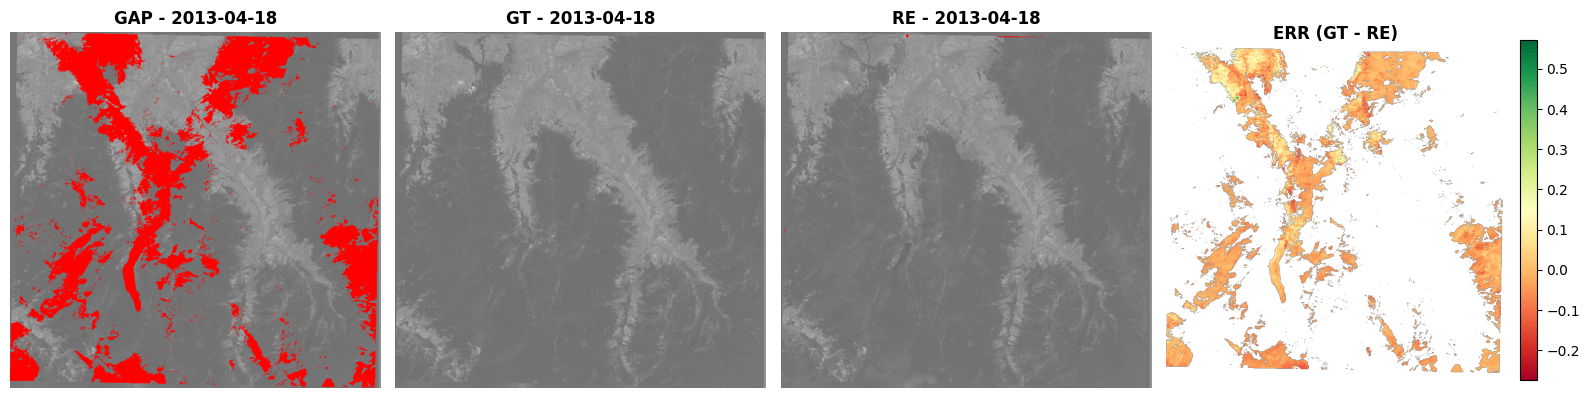

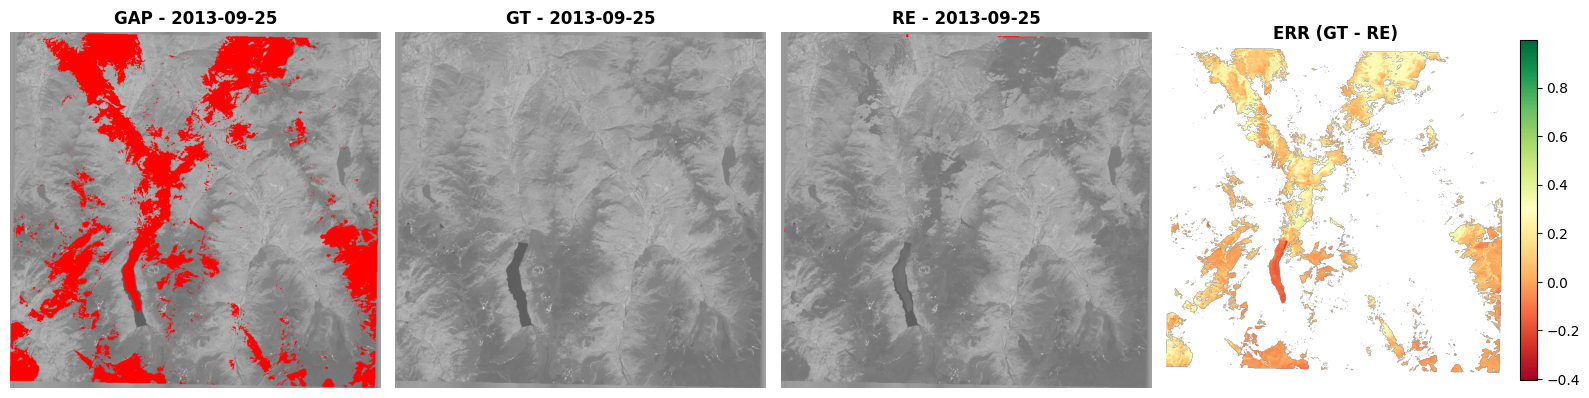

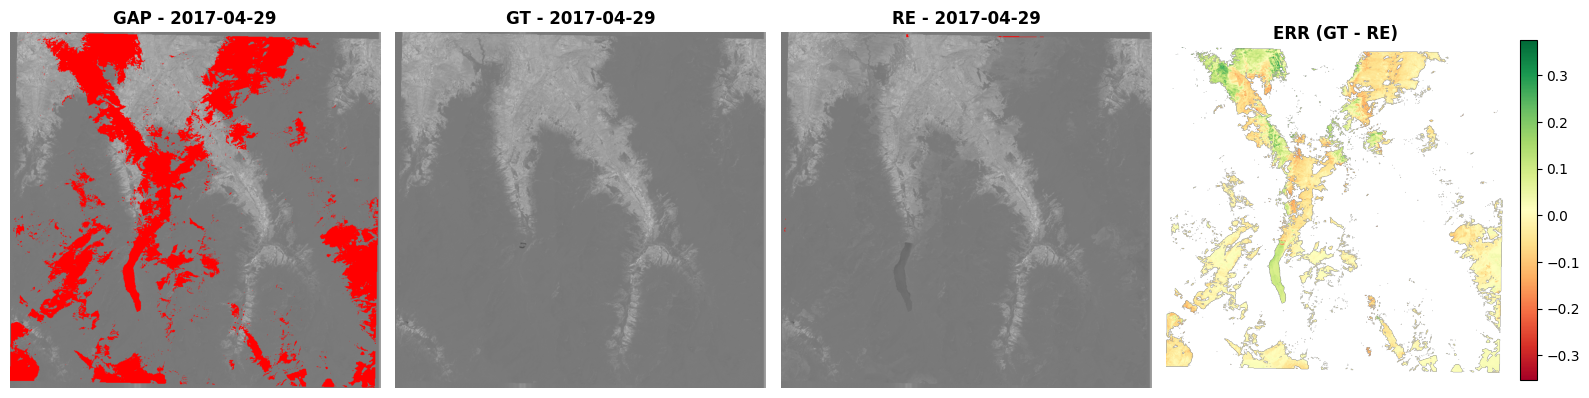

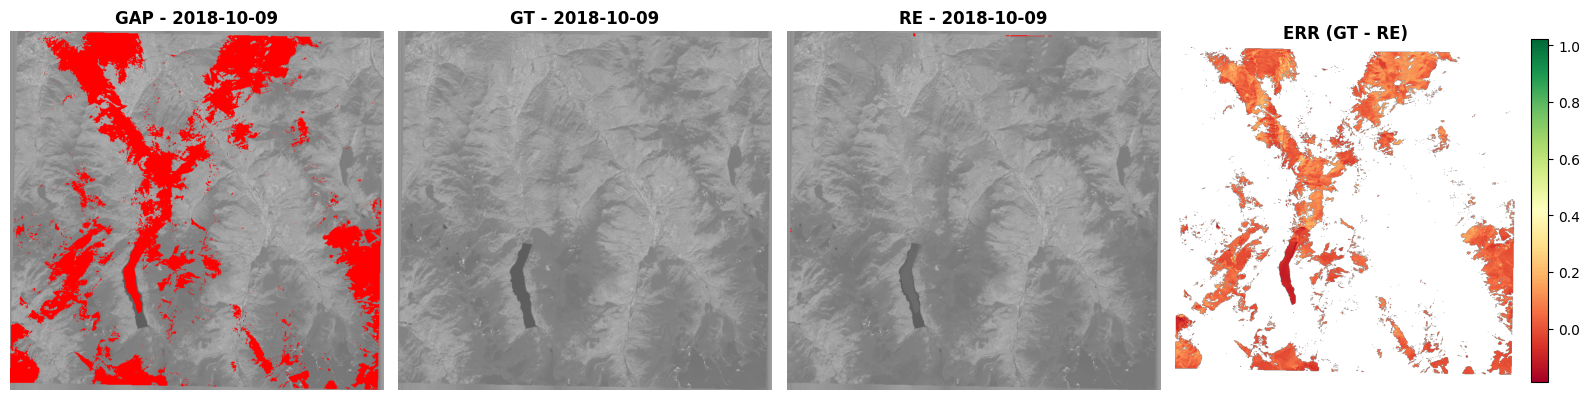

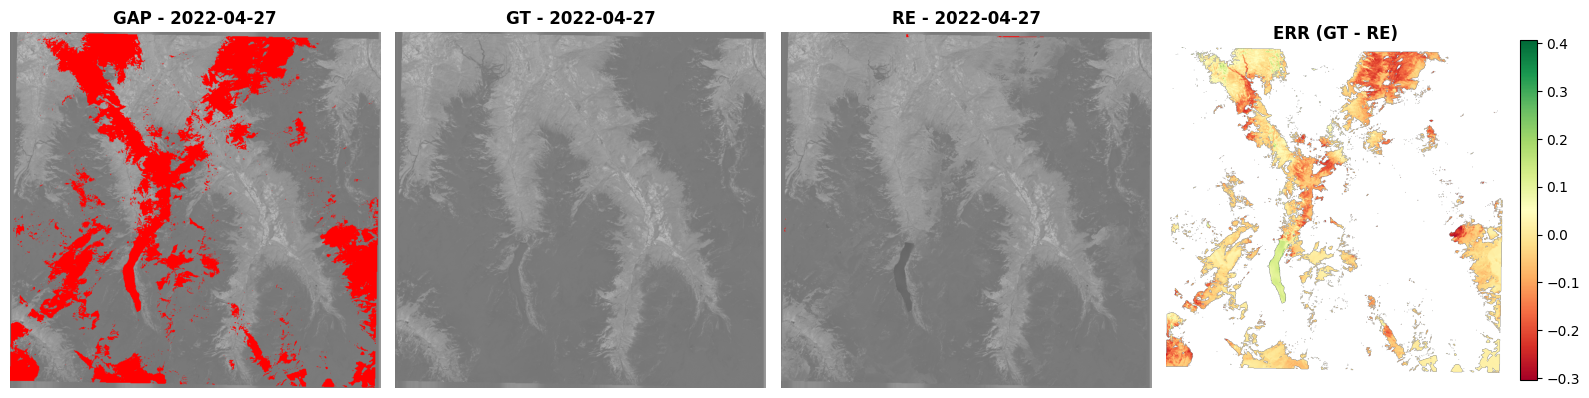

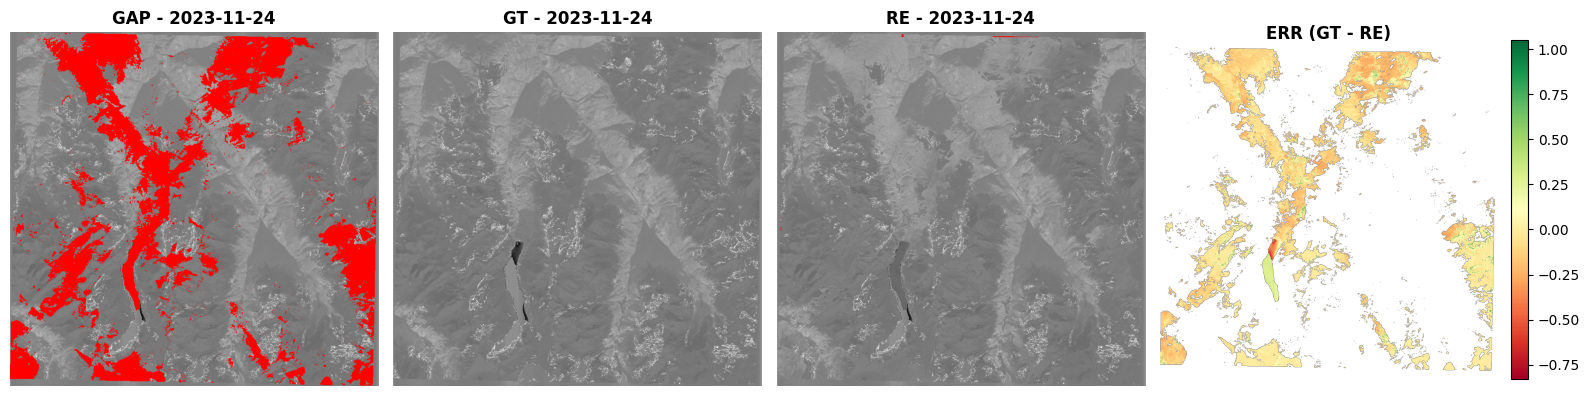

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from rasterio.warp import reproject, Resampling
import rasterio
import os
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/Whitt/NDVI_herens_Landsat8_holes'
gt_dir = '/content/drive/MyDrive/Whitt/NDVI_herens_full'
recon_dir = '/content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, 'recon_*.tif')))

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === Visualisation ===
for i in range(len(hole_files)):
    fname = os.path.basename(hole_files[i])
    date = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture de l'image trouée (référence)
    hole, hole_meta = read_tif_with_meta(hole_files[i])

    # Lecture et alignement des GT et reconstruction
    gt, gt_meta = read_tif_with_meta(gt_files[i])
    gt_resampled = resample_to_match(gt, gt_meta, hole_meta)

    recon, recon_meta = read_tif_with_meta(recon_files[i])
    recon_resampled = resample_to_match(recon, recon_meta, hole_meta)

    # Crée un masque des gaps (NaN dans hole)
    gap_mask = np.isnan(hole)

    # Calcul de l'erreur uniquement sur les pixels des gaps
    err = np.full_like(hole, np.nan)
    valid_mask = gap_mask & ~np.isnan(gt_resampled) & ~np.isnan(recon_resampled)
    err[valid_mask] = gt_resampled[valid_mask] - recon_resampled[valid_mask]
    #err = gt_resampled - recon_resampled
    # === Figure ===
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # === Création d'une colormap grise avec NaN en rouge ===
    cmap_gray_red = plt.cm.gray
    cmap_gray_red.set_bad(color='red')  # NaN en rouge

    # 1) GAP
    axs[0].imshow(np.ma.masked_invalid(hole), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[0].set_title(f'GAP - {date}', fontweight='bold')
    axs[0].axis('off')

    # 2) GT
    axs[1].imshow(np.ma.masked_invalid(gt_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[1].set_title(f'GT - {date}', fontweight='bold')
    axs[1].axis('off')

    # 3) Reconstruction
    axs[2].imshow(np.ma.masked_invalid(recon_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[2].set_title(f'RE - {date}', fontweight='bold')
    axs[2].axis('off')

    # 4) Erreur (GT - RE)
    im4 = axs[3].imshow(np.ma.masked_invalid(err), cmap='RdYlGn')
    axs[3].set_title('ERR (GT - RE)', fontweight='bold')
    axs[3].axis('off')
    plt.colorbar(im4, ax=axs[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling
from sklearn.metrics import mean_squared_error, r2_score
import torch
import piq
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/Whitt/NDVI_herens_Landsat8_holes'
gt_dir = '/content/drive/MyDrive/Whitt/NDVI_herens_full'
recon_dir = '/content/drive/MyDrive/Whitt/egfwh_herens_outputs_multisource2'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, 'recon_*.tif')))

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    """Reprojette et recadre une image pour matcher une autre."""
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === Fonction metrics ===
def evaluate_metrics(gt_img, recon_img, gap_mask, image_name):
    """
    Calcul des metrics uniquement sur les pixels manquants (gap_mask = True)
    """
    valid_mask = gap_mask & ~np.isnan(gt_img) & ~np.isnan(recon_img)
    if np.sum(valid_mask) == 0:
        return pd.DataFrame([{
            'Image name': image_name,
            'RMSE': np.nan, 'R²': np.nan, 'MAE': np.nan,
            'MS-SSIM': np.nan, '% reconstructed pixels': 0.0
        }])

    y_true = gt_img[valid_mask]
    y_pred = recon_img[valid_mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred) if np.var(y_true) > 1e-8 else np.nan
    mae = np.mean(np.abs(y_true - y_pred))

    # Normalisation pour MS-SSIM uniquement sur pixels valides
    min_val = np.min([y_true.min(), y_pred.min()])
    max_val = np.max([y_true.max(), y_pred.max()])
    if max_val - min_val < 1e-8:
        ms_ssim_score = np.nan
    else:
        gt_norm = (gt_img - min_val) / (max_val - min_val)
        recon_norm = (recon_img - min_val) / (max_val - min_val)
        gt_norm[~valid_mask] = 0.0
        recon_norm[~valid_mask] = 0.0
        gt_tensor = torch.from_numpy(gt_norm).unsqueeze(0).unsqueeze(0).float()
        recon_tensor = torch.from_numpy(recon_norm).unsqueeze(0).unsqueeze(0).float()
        ms_ssim_score = piq.multi_scale_ssim(gt_tensor, recon_tensor, data_range=1., reduction='none').item()

    coverage = (np.sum(valid_mask) / np.sum(gap_mask)) * 100 if np.sum(gap_mask) > 0 else 0.0

    results = {
        'Image name': image_name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MS-SSIM': ms_ssim_score,
        '% reconstructed pixels': coverage
    }
    return pd.DataFrame([results])

# === Calcul des metrics pour toutes les images ===
all_results = []

for hole_path in hole_files:
    fname = os.path.basename(hole_path)
    date_str = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture et alignement de l'image trouée
    hole_img, hole_meta = read_tif_with_meta(hole_path)

    # Ground truth
    gt_path = [f for f in gt_files if date_str in f][0]
    gt_img, gt_meta = read_tif_with_meta(gt_path)
    gt_resampled = resample_to_match(gt_img, gt_meta, hole_meta)

    # Reconstruction
    recon_path = [f for f in recon_files if date_str in f][0]
    recon_img, recon_meta = read_tif_with_meta(recon_path)
    recon_resampled = resample_to_match(recon_img, recon_meta, hole_meta)

    # Gap mask (pixels manquants dans l'image trouée)
    gap_mask = np.isnan(hole_img)

    # Metrics
    df = evaluate_metrics(gt_resampled, recon_resampled, gap_mask, fname)
    all_results.append(df)

# Table finale
metrics_table = pd.concat(all_results, ignore_index=True)
metrics_table

,Image name,RMSE,R²,MAE,MS-SSIM,% reconstructed pixels
0,NDVI_2013-04-18.tif,0.054271,0.744494,0.040830,0.977253,99.852422
1,NDVI_2013-09-25.tif,0.159961,-0.163525,0.124621,0.958039,99.852422
2,NDVI_2017-04-29.tif,0.063456,0.662403,0.047323,0.988225,99.852422
3,NDVI_2018-10-09.tif,0.078604,0.629309,0.060216,0.974116,99.852422
4,NDVI_2022-04-27.tif,0.088192,0.321904,0.066181,0.951678,99.852422
5,NDVI_2023-11-24.tif,0.153097,-0.193761,0.110780,0.980962,99.852422


ValueError: x and y must have same first dimension, but have shapes (66,) and (6,)

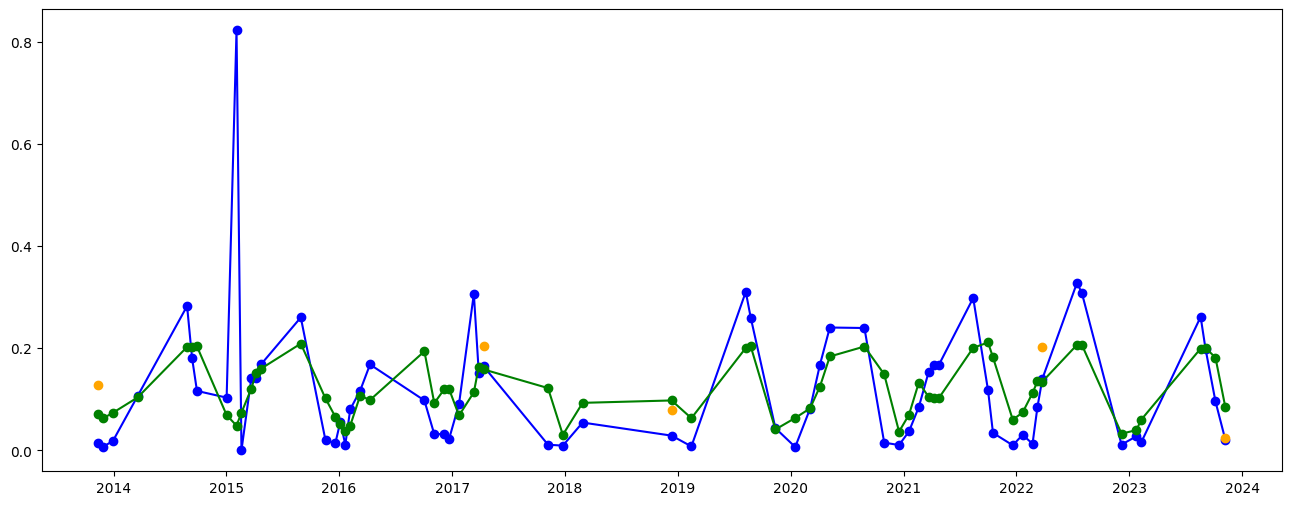

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- Paramètres du pixel / patch ---
i_pixel, j_pixel = 100, 120  # exemple, à adapter
patch_size = 1  # si patch_size >1, extraire la moyenne du patch

# --- Fonctions helper ---
def extract_patch_stack(stack, i, j, size=1):
    """Retourne la série temporelle pour un pixel ou un patch (moyenne)."""
    T, H, W = stack.shape
    half = size // 2
    i0, i1 = max(0, i-half), min(H, i+half+1)
    j0, j1 = max(0, j-half), min(W, j+half+1)
    patch = stack[:, i0:i1, j0:j1]
    return np.nanmean(patch.reshape(T, -1), axis=1)

# --- Extraire les séries ---
ndvi_clear_full = extract_patch_stack(landsat_clear_stack, i_pixel, j_pixel, patch_size)
ndvi_recon_full = extract_patch_stack(final_stack, i_pixel, j_pixel, patch_size)
ndvi_whittaker_full = extract_patch_stack(SLM, i_pixel, j_pixel, patch_size)

# Création de la série masked alignée sur la stack complète
ndvi_masked_full = np.full_like(ndvi_clear_full, np.nan, dtype=float)
for t, date_masked in enumerate(masked_dates):
    # trouver l'indice de la date la plus proche dans clear_dates
    diffs = [abs((cd - date_masked).days) for cd in clear_dates]
    idx = np.argmin(diffs)
    ndvi_masked_full[idx] = extract_patch_stack(landsat_masked_stack, i_pixel, j_pixel, patch_size)[t]

# --- Dates pour l'axe X ---
dates_dt = clear_dates  # on prend la stack complète Landsat

# --- Plot ---
plt.figure(figsize=(16,6))
plt.plot(dates_dt, ndvi_clear_full, 'o-', color='blue', label='Landsat original')
plt.plot(dates_dt, ndvi_masked_full, 'o-', color='orange', label='Landsat masked')
plt.plot(dates_dt, ndvi_whittaker_full, 'o-', color='green', label='Whittaker intermediate')
plt.plot(dates_dt, ndvi_recon_full, 'o-', color='red', label='Reconstruction finale')

plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title(f"Série temporelle NDVI pixel ({i_pixel}, {j_pixel})")
plt.legend()
plt.grid(True)
plt.show()
